In [113]:
import os, sys
import platform
import json
import getpass
import requests
import geopandas as gpd
import xml.etree.ElementTree as ET
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
host = r'https://espa.cr.usgs.gov/api/v1/'

username='joemcglinchy'
password = getpass.getpass()

········


In [152]:
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data
        
        
def ee_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

def getCC_from_meta(meta_url):
    
    r_meta = requests.get(meta_url)
    root = ET.fromstring(r_meta.text)
    prod_id_string = root.findall('./{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataFields/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataField/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataValue')[0].text
    if 'LC08' in prod_id_string:
        cc_string = root.findall('./{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataFields/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataField/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataValue')[16].text
    else:
        cc_string = root.findall('./{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataFields/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataField/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataValue')[15].text
    
    cc_int = float(cc_string)
    
    return cc_int


print('GET /api/v1/user')       
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "joseph.mcglinchy@colorado.edu",
    "first_name": "Joe",
    "last_name": "McGlinchy",
    "roles": [
        "active"
    ],
    "username": "joemcglinchy"
}


In [4]:
## the entire 10k buffer polygon is contained within Path/Row 168/77... Let's work with that for now
l_path = 168
l_row = 77

In [5]:
shpfile = '../bounding_box/minbound10k_WGS84.shp'
shp = gpd.read_file(shpfile)
bounds = shp['geometry'][0].bounds
bounds

# would return:
'''
(31.01958199302162,
 -25.068105363674974,
 31.535826264860678,
 -24.63766714051666)
 
 -25.068105363674974,31.01958199302162,-24.63766714051666, 31.535826264860678
 
 
 
'''

'\n(31.01958199302162,\n -25.068105363674974,\n 31.535826264860678,\n -24.63766714051666)\n \n -25.068105363674974,31.01958199302162,-24.63766714051666, 31.535826264860678\n \n \n \n'

In [168]:
# URL for earth explorer API
ee_url = r'https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/login'

# credentials for earth explorer
creds={"username": username,
    "password": password,
    "authType": "",
    "catalogId": "EE"}    

# get a token
r = requests.post(ee_url, params={'jsonRequest':json.dumps(creds)})
r.json()
r.url

token = r.json()['data']

# construct a search for collection 1 scenes
#datasetName = LANDSAT_8_C1, LANDSAT_ETM_C1, LANDSAT_TM_C1
#maxCloudCover = <int>

scene_ids = []
all_results = []
cloud_covers = []
for dataset in ['LANDSAT_8_C1', 'LANDSAT_ETM_C1', 'LANDSAT_TM_C1']:
    
    # the search dictionary
    search={"datasetName": dataset,
            "spatialFilter": {
                "filterType": "mbr",
                "lowerLeft": {
                        "latitude": bounds[1],
                        "longitude": bounds[0]
                },
                "upperRight": {
                        "latitude": bounds[3],
                        "longitude": bounds[2]
                }
            },
            "temporalFilter": {
                "dateField": "search_date",
                #"startDate": "2007-01-01",
                #"endDate": "2014-12-31"
                "startDate": "1997-01-01",
                "endDate": "2017-12-31"
            },
            "maxResults": 2000,
            #"maxCloudCover": 20,
            #"minCloudCover": 21,
            "additionalCriteria": {
            "filterType": "and", 
            "childFilters": [
                {"filterType":"value","fieldId":"21989","operand":"like","value":"168"}, #path
                {"filterType":"value","fieldId":"19879","operand":"like","value":"77"},  #row
                {"filterType":"value","fieldId":"19880","operand":"like","value":"T1"}   #processing level
                ]
            },
            "apiKey": "{}".format(token)}
    url='https://earthexplorer.usgs.gov/inventory/json/v/1.4.0/search'

    r = requests.get(url, params={'jsonRequest':json.dumps(search)})
    #r.json()
    
    # check the results_list against processing level and path/row
    try:
        
        results_list = r.json()['data']['results']
        all_results.append(results_list)
        
        # get cloud covers
        cc_list = [getCC_from_meta(cur_res['metadataUrl']) for cur_res in results_list]
        cloud_covers.append(cc_list)
                
        ids_to_order = []
        for res in results_list:
            
            # check that the data is level T1
            data_level = res['displayId'].split('_')[-1]
            if not 'T1' in data_level:
                #print(data_level)
                continue

            # check the path row is correct
            temp = res['summary'].split(',')
            t_path = int(temp[-2].split('Path: ')[-1])
            t_row = int(temp[-1].split('Row: ')[-1])

            if t_path!=l_path or t_row!=t_row:
                continue

            ids_to_order.append(res['displayId'])

        scene_ids.append(ids_to_order)
    
    except Exception as e:
        print(e)
        print('datasetName: ', dataset, ' returned 0 results')
        continue

In [169]:
## do some dataframe stuff for acquisition month
sens_ind = 1                                    # 0-->landsat 8, 1-->landsat 7, 2-->landsat 5
test = pd.DataFrame(all_results[sens_ind])
test.loc[:,'cc_scene'] = pd.Series(cloud_covers[sens_ind], index=test.index)
acqMonth_num = [int(datestring.split('-')[1]) for datestring in test['acquisitionDate']]
acqYear_num = [int(datestring.split('-')[0]) for datestring in test['acquisitionDate']]
test.loc[:,'acqMonth_num'] = pd.Series(acqMonth_num, index=test.index)
test.loc[:,'acqYear_num'] = pd.Series(acqYear_num, index=test.index)

test.head()

,acquisitionDate,browseUrl,bulkOrdered,dataAccessUrl,displayId,downloadUrl,endTime,entityId,fgdcMetadataUrl,metadataUrl,modifiedDate,orderUrl,ordered,sceneBounds,spatialFootprint,startTime,summary,cc_scene,acqMonth_num,acqYear_num
0,1999-08-13,https://earthexplorer.usgs.gov/browse/landsat_...,False,https://earthexplorer.usgs.gov/order/process?d...,LE07_L1TP_168077_19990813_20170217_01_T1,https://earthexplorer.usgs.gov/download/extern...,1999-08-13,LE71680771999225EDC00,https://earthexplorer.usgs.gov/fgdc/12267/LE71...,https://earthexplorer.usgs.gov/metadata/xml/12...,2018-06-20,https://earthexplorer.usgs.gov/order/process?d...,False,"30.773,-25.5014,33.0452,-23.6023","{'type': 'Polygon', 'coordinates': [[[30.773, ...",1999-08-13,Entity ID: LE07_L1TP_168077_19990813_20170217_...,1.0,8,1999
1,1999-10-16,https://earthexplorer.usgs.gov/browse/landsat_...,False,https://earthexplorer.usgs.gov/order/process?d...,LE07_L1TP_168077_19991016_20170216_01_T1,https://earthexplorer.usgs.gov/download/extern...,1999-10-16,LE71680771999289EDC00,https://earthexplorer.usgs.gov/fgdc/12267/LE71...,https://earthexplorer.usgs.gov/metadata/xml/12...,2018-06-20,https://earthexplorer.usgs.gov/order/process?d...,False,"30.7544,-25.5014,33.0269,-23.6022","{'type': 'Polygon', 'coordinates': [[[30.7544,...",1999-10-16,Entity ID: LE07_L1TP_168077_19991016_20170216_...,0.0,10,1999
2,1999-12-19,https://earthexplorer.usgs.gov/browse/landsat_...,False,https://earthexplorer.usgs.gov/order/process?d...,LE07_L1TP_168077_19991219_20170215_01_T1,https://earthexplorer.usgs.gov/download/extern...,1999-12-19,LE71680771999353EDC00,https://earthexplorer.usgs.gov/fgdc/12267/LE71...,https://earthexplorer.usgs.gov/metadata/xml/12...,2018-06-20,https://earthexplorer.usgs.gov/order/process?d...,False,"30.7503,-25.5016,33.023,-23.6023","{'type': 'Polygon', 'coordinates': [[[30.7503,...",1999-12-19,Entity ID: LE07_L1TP_168077_19991219_20170215_...,0.0,12,1999
3,2000-03-24,https://earthexplorer.usgs.gov/browse/landsat_...,False,https://earthexplorer.usgs.gov/order/process?d...,LE07_L1TP_168077_20000324_20170212_01_T1,https://earthexplorer.usgs.gov/download/extern...,2000-03-24,LE71680772000084EDC00,https://earthexplorer.usgs.gov/fgdc/12267/LE71...,https://earthexplorer.usgs.gov/metadata/xml/12...,2018-06-20,https://earthexplorer.usgs.gov/order/process?d...,False,"30.765,-25.502,33.0372,-23.6024","{'type': 'Polygon', 'coordinates': [[[30.765, ...",2000-03-24,Entity ID: LE07_L1TP_168077_20000324_20170212_...,31.0,3,2000
4,2000-04-09,https://earthexplorer.usgs.gov/browse/landsat_...,False,https://earthexplorer.usgs.gov/order/process?d...,LE07_L1TP_168077_20000409_20170212_01_T1,https://earthexplorer.usgs.gov/download/extern...,2000-04-09,LE71680772000100EDC00,https://earthexplorer.usgs.gov/fgdc/12267/LE71...,https://earthexplorer.usgs.gov/metadata/xml/12...,2018-06-20,https://earthexplorer.usgs.gov/order/process?d...,False,"30.7901,-25.5016,33.0616,-23.6021","{'type': 'Polygon', 'coordinates': [[[30.7901,...",2000-04-09,Entity ID: LE07_L1TP_168077_20000409_20170212_...,2.0,4,2000


In [216]:
test.shape

(215, 20)

(3, 20)
(3, 3)


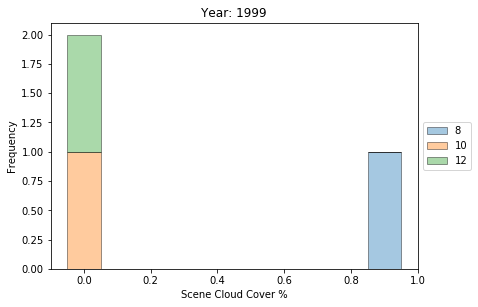

(9, 20)
(9, 6)


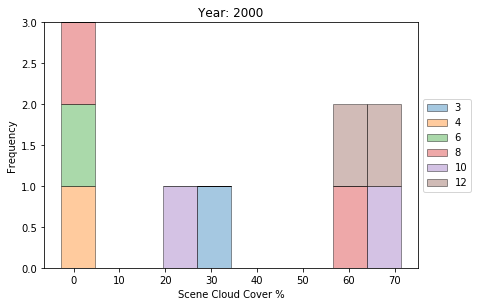

(12, 20)
(12, 10)


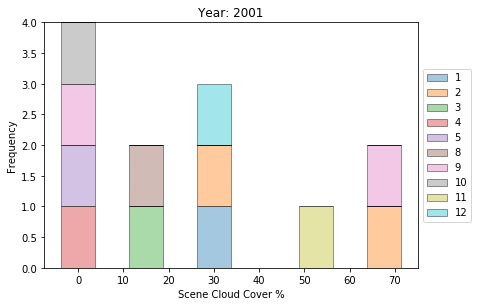

(15, 20)
(15, 11)


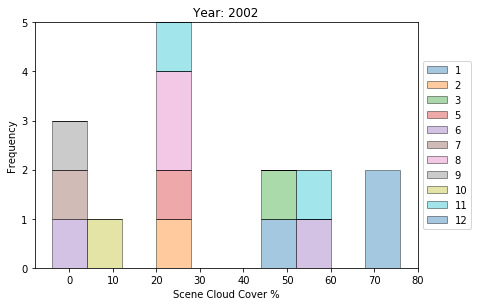

(8, 20)
(8, 6)


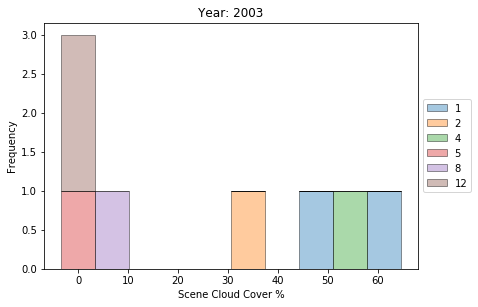

(10, 20)
(10, 8)


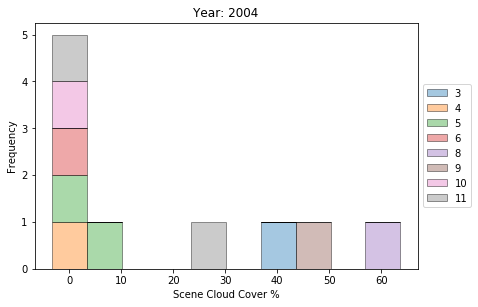

(9, 20)
(9, 9)


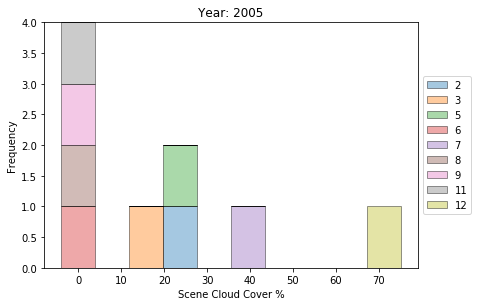

(10, 20)
(10, 7)


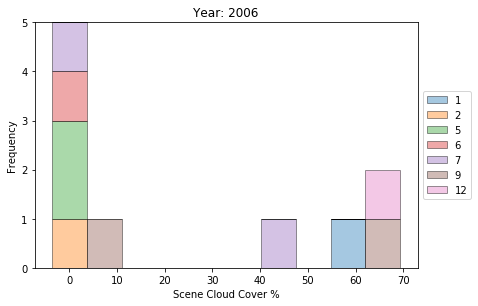

(12, 20)
(12, 9)


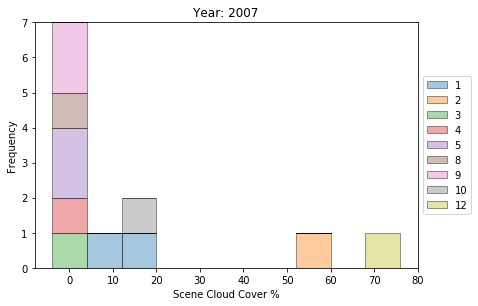

(10, 20)
(10, 7)


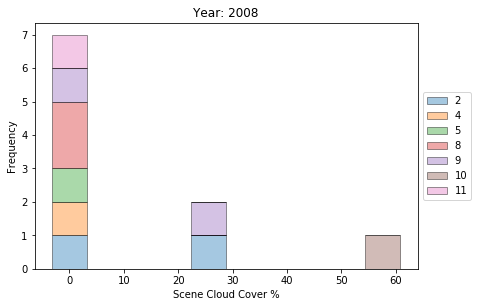

(5, 20)
(5, 4)


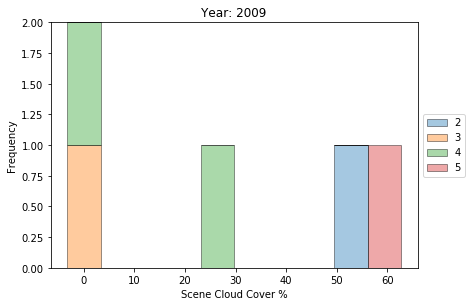

(10, 20)
(10, 7)


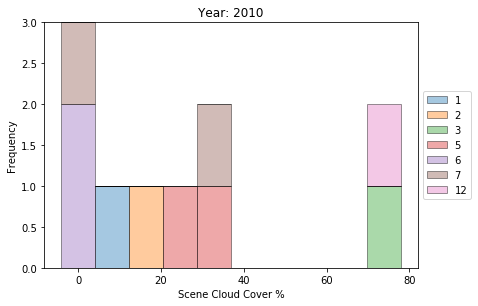

(11, 20)
(11, 9)


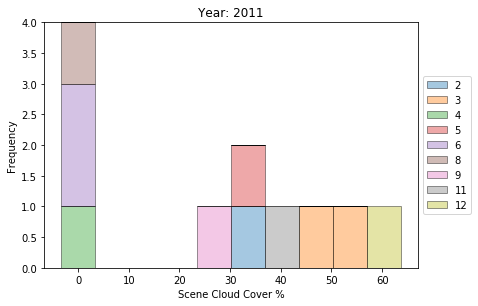

(18, 20)
(18, 12)


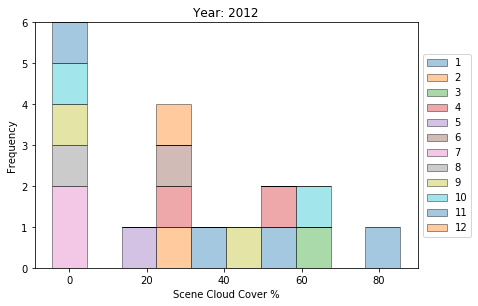

(13, 20)
(13, 10)


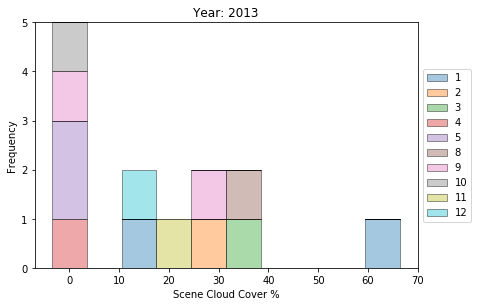

(17, 20)
(17, 11)


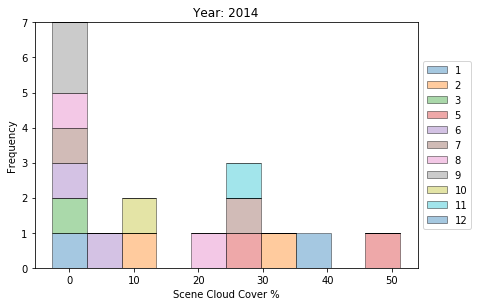

(12, 20)
(12, 11)


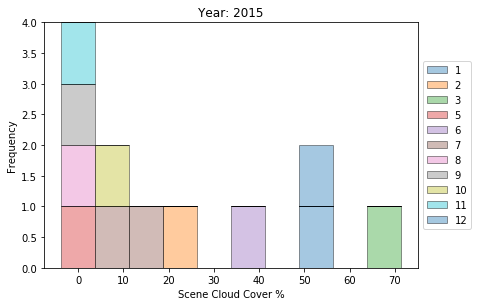

(15, 20)
(15, 10)


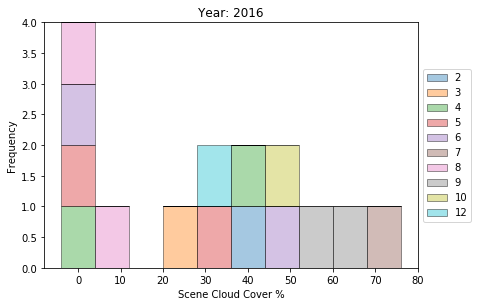

(16, 20)
(16, 10)


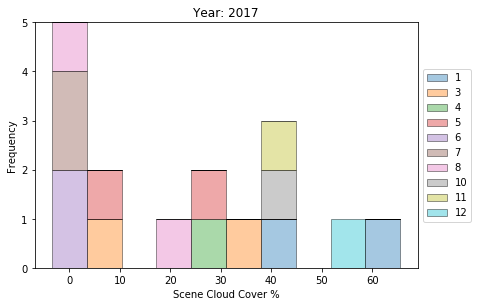

In [220]:
months = ['bog', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for name, group in test.groupby('acqYear_num'):
    
    print(group.shape)
    
    temp = pd.DataFrame({k: v for k, v in group.groupby('acqMonth_num').cc_scene})
    temp.plot.hist(stacked=True, alpha=0.4, edgecolor='k', align='left')
    
    print(temp.shape)
    
    
    # get the axis
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    #plt.title('Month: {}'.format(months[name]))
    plt.title('Year: {}'.format(name))
    plt.xlabel('Scene Cloud Cover %')
    plt.show()



### Code to retrieve cloud cover for scene

In [42]:
#scene_ids
import xml.etree.ElementTree as ET
r_meta = requests.get('https://earthexplorer.usgs.gov/metadata/xml/12266/LT51680772011042JSA00/')
root = ET.fromstring(r_meta.text)
cc_string = root.findall('./{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataFields/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataField/{http://earthexplorer.usgs.gov/eemetadata.xsd}metadataValue')[15].text
cc_int = int(cc_string)

('{http://earthexplorer.usgs.gov/eemetadata.xsd}scene',
 {'link': 'https://earthexplorer.usgs.gov/metadata/12266/LT51680772011042JSA00/'})

In [85]:
results_list[0]['metadataUrl']

'https://earthexplorer.usgs.gov/metadata/xml/12266/LT51680772007095JSA00/'

In [19]:
flat_list = []
for item_ls in scene_ids:
    flat_list += item_ls
    
flat_list

['LC08_L1TP_168077_20130407_20170505_01_T1',
 'LC08_L1TP_168077_20130523_20180526_01_T1',
 'LC08_L1TP_168077_20130608_20170504_01_T1',
 'LC08_L1TP_168077_20130624_20170504_01_T1',
 'LC08_L1TP_168077_20130726_20170503_01_T1',
 'LC08_L1TP_168077_20130827_20170502_01_T1',
 'LC08_L1TP_168077_20131115_20170428_01_T1',
 'LC08_L1TP_168077_20140323_20170425_01_T1',
 'LC08_L1TP_168077_20140510_20170422_01_T1',
 'LC08_L1TP_168077_20140526_20170422_01_T1',
 'LC08_L1TP_168077_20140611_20170422_01_T1',
 'LC08_L1TP_168077_20140627_20170421_01_T1',
 'LC08_L1TP_168077_20140713_20170421_01_T1',
 'LC08_L1TP_168077_20140814_20180526_01_T1',
 'LC08_L1TP_168077_20140830_20170420_01_T1',
 'LC08_L1TP_168077_20140915_20170419_01_T1',
 'LC08_L1TP_168077_20141001_20170418_01_T1',
 'LC08_L1TP_168077_20141204_20170417_01_T1',
 'LE07_L1TP_168077_20070107_20170105_01_T1',
 'LE07_L1TP_168077_20070123_20170105_01_T1',
 'LE07_L1TP_168077_20070312_20170104_01_T1',
 'LE07_L1TP_168077_20070429_20170103_01_T1',
 'LE07_L1T

In [20]:
## write out a text file to order the scenes
out_txt = 'scene_order.txt'
ctr = 1
with open(out_txt, 'w') as fi:
    for sid in flat_list[:40]:
        fi.write(sid + '\n')
        ctr +=1


out_txt = 'scene_order1.txt'
with open(out_txt, 'w') as fi:
    for sid in flat_list[40:]:
        fi.write(sid + '\n')
        ctr +=1
            
print(ctr, 'files to be ordered')

86 files to be ordered
